In [235]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time
import random
import pandas as pd
import yaml
from collections import Counter
import re

from argparse import Namespace

import numpy as np
import networkx as nx
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

root_dir = os.path.dirname(
        os.path.dirname(os.path.realpath(".")))

sys.path.append(root_dir)


import logging

from rl_envs_forge.envs.grid_world.grid_world import GridWorld
from common.src.distribution_src import ( 
                                         make_env, 
                                        randomize_walls_positions, 
                                        generate_train_test_split_with_valid_path,
                                        run_distribution_correction_experiment,
                                        compute_validation_bellmans_error,
                                        setup_dqn_agent
                                        )
from common.src.simple_dqn_agent import AgentDQN
from common.src.replay_buffer import ReplayBuffer

from scipy.stats import entropy


from common.src.experiment_utils import (
    setup_logger,
    namespace_to_dict,
)

from common.src.distribution_src import run_dqn_distribution_correction_experiment

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from argparse import Namespace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[(2, 0), (1, 2)]


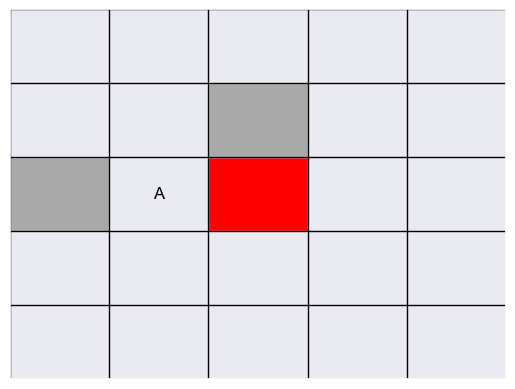

In [236]:
terminal_states = {(2, 2): 1}
start_state = (2, 1)
rows = 5
cols = 5
seed = 2

# random_walls = randomize_walls_positions(rows, cols, start_state, terminal_states, 0.2, seed=seed)
random_walls = [(2, 0), (1, 2)]
print(random_walls)
env = make_env(
    rows,
    cols,
    start_state=start_state,
    p_success=1,
    terminal_states=terminal_states,
    seed=seed,
    walls=random_walls,
)
env.render()

In [237]:
def get_observation_space_shape(observation_space):
    """Extract a shape-like tuple from a tuple of discrete spaces."""
    return tuple(space.n for space in observation_space.spaces)

In [238]:
env.observation_space

Tuple(Discrete(5), Discrete(5))

In [239]:
env.state

(2, 1)

In [240]:
def state_to_matrix(state, env):
    import numpy as np

    # Extract the environment size from walls and terminal states
    max_rows = env.rows
    max_cols = env.cols

    # Create the matrix
    matrix = np.zeros((max_rows, max_cols), dtype=int)

    # Mark walls in the matrix
    for wall in env.walls:
        matrix[wall[0], wall[1]] = 1  # Use 1 to indicate walls

    # Mark terminal states in the matrix
    for terminal, value in env.terminal_states.items():
        matrix[terminal[0], terminal[1]] = 2

    pos = state
    matrix[pos[0], pos[1]] = 3  # Use 3 to indicate the agent's position

    return matrix


state_to_matrix(env.state, env)

array([[0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 3, 2, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [241]:
state_shape = get_observation_space_shape(env.observation_space)
state_shape

(5, 5)

In [242]:
# env.mdp

In [243]:
# ts = next(iter(terminal_states))

# for trial in range(100000):
#     random_walls = randomize_walls_positions(rows, cols, start_state, terminal_states, 0.2, seed=trial)

#     if (start_state in random_walls) or (ts in random_walls):
#         raise ValueError("start state or terminal state in walls")

In [244]:
transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]

transitions_train, transitions_val = generate_train_test_split_with_valid_path(
    transitions_list=transitions_list,
    start_state=start_state,
    terminal_states=terminal_states,
)

In [245]:
### Load up a config

file_path = r"D:\Work\repos\phd-research\experiments\dqn\results\2024Jun12-192714_configs\0000_algorithm_default\0\cfg.yaml"

# Open the YAML file and load its content into a dictionary
with open(file_path, "r") as file:
    data = yaml.safe_load(file)

opts = Namespace(**data)

logger = setup_logger(opts.full_title)

opts.seed = random.randint(0, 2**32 - 1) if opts.seed is None else opts.seed
opts_dict = namespace_to_dict(opts)
# opts_dict = vars(opts)

opts_dict

{'agent_params': {'agent': 'AgentDQN',
  'args_': {'batch_size': 32,
   'epsilon': {'decay': 10000, 'end': 0.01, 'start': 1.0},
   'gamma': 0.9,
   'loss_fcn': 'mse_loss',
   'replay_start_size': 500,
   'target_model_update_freq': 50,
   'train_step_cnt': 500,
   'training_freq': 4,
   'validation_enabled': False,
   'validation_epsilon': 0.001,
   'validation_step_cnt': 250}},
 'algorithm': 'default',
 'cfg_id': 0,
 'cols': 10,
 'experiment': 'experiment_distributions',
 'experiment_arguments': {'algorithm': 'default'},
 'full_title': '2024Jun12-192714_configs_algorithm=default',
 'neural_fit_mode': 'max',
 'num_steps': 40000,
 'optim': {'args_': {'eps': 0.0003125, 'lr': 0.001}, 'name': 'Adam'},
 'out_dir': '.\\results\\2024Jun12-192714_configs\\0000_algorithm_default\\0',
 'p_success': 1,
 'replay_buffer': {'action_dim': 1, 'max_size': 1000, 'n_step': 0},
 'rows': 10,
 'run_id': 0,
 'seed': 3778673845,
 'start_state': (1, 1),
 'terminal_states': {(8, 8): 1.0},
 'title': 'algorithm=d

In [246]:
opts

Namespace(agent_params={'agent': 'AgentDQN', 'args_': {'batch_size': 32, 'epsilon': {'decay': 10000, 'end': 0.01, 'start': 1.0}, 'gamma': 0.9, 'loss_fcn': 'mse_loss', 'replay_start_size': 500, 'target_model_update_freq': 50, 'train_step_cnt': 500, 'training_freq': 4, 'validation_enabled': False, 'validation_epsilon': 0.001, 'validation_step_cnt': 250}}, algorithm='default', cfg_id=0, cols=10, experiment='experiment_distributions', experiment_arguments={'algorithm': 'default'}, full_title='2024Jun12-192714_configs_algorithm=default', neural_fit_mode='max', num_steps=40000, optim={'args_': {'eps': 0.0003125, 'lr': 0.001}, 'name': 'Adam'}, out_dir='.\\results\\2024Jun12-192714_configs\\0000_algorithm_default\\0', p_success=1, replay_buffer={'action_dim': 1, 'max_size': 1000, 'n_step': 0}, rows=10, run_id=0, seed=3778673845, start_state='(1, 1)', terminal_states={'(8, 8)': 1.0}, title='algorithm=default', train_max_iterations=40)

In [247]:
opts_dict["start_state"]

(1, 1)

In [248]:
opts_dict["terminal_states"]

{(8, 8): 1.0}

In [249]:
logger.info(f"Starting experiment: {opts_dict['full_title']}")

agent = setup_dqn_agent(
    config=opts_dict,
    logger=logger,
)

transitions_list = [
    (key[0], key[1], *value[0]) for key, value in agent.train_env.mdp.items()
]

experiment_data = []
for i in range(1, 30):
    agent.train(i)

    bm_error_validation = compute_validation_bellmans_error(
        agent.target_model,
        validation_transitions=transitions_list,
        error_mode=opts_dict["neural_fit_mode"],
        gamma=agent.gamma,
        logger=logger,
    )

    rb_entropy = agent.replay_buffer.calculate_buffer_entropy()

    normalized_rb = agent.replay_buffer.normalize_replay_buffer()
    normalized_rb_entropy = normalized_rb.calculate_buffer_entropy()

# experiment_agent.train(3)

2024-06-12 19:27:33,863 - 2024Jun12-192714_configs_algorithm=default - INFO - Starting experiment: 2024Jun12-192714_configs_algorithm=default
2024-06-12 19:27:33,864 - 2024Jun12-192714_configs_algorithm=default - INFO - Starting experiment: 2024Jun12-192714_configs_algorithm=default
2024-06-12 19:27:33,869 - 2024Jun12-192714_configs_algorithm=default - INFO - Loaded configuration settings.
2024-06-12 19:27:33,870 - 2024Jun12-192714_configs_algorithm=default - INFO - Initialized newtworks and optimizer.
2024-06-12 19:27:33,871 - 2024Jun12-192714_configs_algorithm=default - INFO - Starting training session at: 0
2024-06-12 19:27:33,872 - 2024Jun12-192714_configs_algorithm=default - INFO - Starting training epoch at t = 0
2024-06-12 19:27:33,875 - 2024Jun12-192714_configs_algorithm=default - INFO - Episode 0 terminated at frame 103 with reward 1.0
2024-06-12 19:27:33,885 - 2024Jun12-192714_configs_algorithm=default - INFO - TRAINING STATS | Frames seen: 500 | Episode: 1 | Max reward: -18.

D:\Work\repos\phd-research\common\src\simple_dqn_agent.py:736: RuntimeWarning: All-NaN axis encountered
  stats["median"] = np.nanmedian(vector)
D:\Work\repos\phd-research\common\src\simple_dqn_agent.py:737: RuntimeWarning: All-NaN axis encountered
  stats["std"] = np.nanstd(vector)
D:\Work\repos\phd-research\common\src\simple_dqn_agent.py:738: RuntimeWarning: Mean of empty slice
  
D:\Work\repos\phd-research\common\src\simple_dqn_agent.py:739: RuntimeWarning: All-NaN slice encountered
  else:
c:\Users\Chainsword\anaconda3\envs\phd_rl_algos\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2024-06-12 19:27:34,162 - 2024Jun12-192714_configs_algorithm=default - INFO - TRAINING STATS | Frames seen: 1000 | Episode: 1 | Max reward: None | Avg reward: None | Avg frames (episode): None | Avg max Q: None | Epsilon: 0.9505 | Train epoch time: 0:00:00.189674
2024-06-12 19:27:34,163 - 2024Jun12-192714_configs_algorithm=default - INFO - Saving checkpoint at t = 1000 ...
2024-06-12 19:27:34,163 - 2024Jun12-192714_configs_algorithm=default - INFO - Checkpoint saved at t = 1000
2024-06-12 19:27:34,164 - 2024Jun12-192714_configs_algorithm=default - INFO - Epoch 0 completed in 0:00:00.191676. Frames seen: 1000
2024-06-12 19:27:34,164 - 2024Jun12-192714_configs_algorithm=default - INFO - 

2024-06-12 19:27:34,164 - 2024Jun12-192714_configs_algorithm=default - INFO - Ended training session after 1 epochs at t = 1000
2024-06-12 19:27:34,335 - 2024Jun12-192714_configs_algorithm=default - INFO - Resuming training session at: 1000 (1 epochs left)
2024-06-12 19:27:34,336 - 2024Jun12-192714_conf

In [250]:
rbs_folder = os.path.dirname(file_path)

def count_actions_in_buffer(buffer):
    actions = [transition[1] for transition in buffer]
    action_counts = Counter(actions)
    return action_counts

def collect_replay_buffer_data(buffer_directory, base_file_name, agent_replay_buffer):
    data = []
    pattern = re.compile(f".*{base_file_name}_(\d+)$")

    max_size = agent_replay_buffer.max_size
    state_dim = agent_replay_buffer.state_dim
    action_dim = agent_replay_buffer.action_dim
    n_step = agent_replay_buffer.n_step

    # Instantiate a new ReplayBuffer with the same parameters
    
    with os.scandir(buffer_directory) as entries:
        for entry in entries:
            if entry.is_file() and pattern.match(entry.name):
                cycle = int(pattern.search(entry.name).group(1))
                replay_buffer = ReplayBuffer(max_size, state_dim, action_dim, n_step)
    
                replay_buffer.load(entry.path)
                action_counts = count_actions_in_buffer(replay_buffer.buffer)
                action_counts['cycle'] = cycle
                data.append(action_counts)
    
    # Sort data by cycle number
    data = sorted(data, key=lambda x: x['cycle'])
    
    df = pd.DataFrame(data)
    df = df.fillna(0)  # Replace NaN with 0 for missing action counts
    df = df[['cycle'] + sorted([col for col in df.columns if col != 'cycle'])]
    
    return df

df = collect_replay_buffer_data(rbs_folder, 'replay_buffer', agent.replay_buffer)
df

,cycle,0,1,2,3
0,1,274,247,247,232
1,2,238,250,252,260
2,3,245,232,265,258
3,4,245,258,253,244
4,5,216,279,297,208
5,6,201,302,328,169
6,7,109,387,355,149
7,8,119,380,247,254
8,9,170,324,386,120
9,10,203,299,305,193


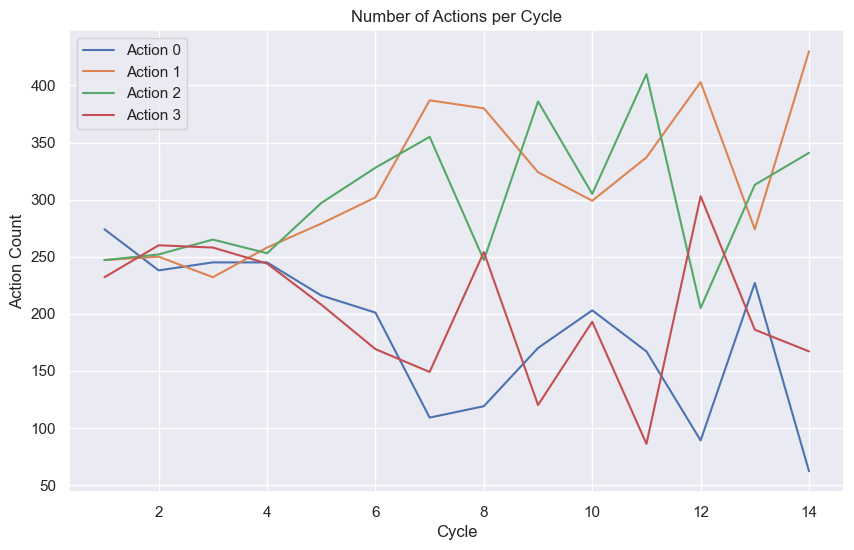

In [251]:
def plot_action_counts(df):
    plt.figure(figsize=(10, 6))
    
    for column in df.columns:
        if column != 'cycle':
            plt.plot(df['cycle'], df[column], label=f"Action {column}")

    plt.xlabel('Cycle')
    plt.ylabel('Action Count')
    plt.title('Number of Actions per Cycle')
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_action_counts(df)

In [252]:
agent.training_stats

[{'frame_stamp': 500,
  'epsilon_greedy': 1.0,
  'episode_rewards': {'min': -18.300000000000004,
   'max': -18.300000000000004,
   'mean': -18.300000000000004,
   'median': -18.300000000000004,
   'std': 0.0},
  'episode_frames': {'min': 104,
   'max': 104,
   'mean': 104.0,
   'median': 104.0,
   'std': 0.0},
  'episode_losses': {'min': None,
   'max': None,
   'mean': None,
   'median': None,
   'std': None},
  'episode_max_qs': {'min': nan,
   'max': nan,
   'mean': nan,
   'median': nan,
   'std': nan},
  'policy_trained_times': 0,
  'target_trained_times': 0,
  'epoch_time': datetime.timedelta(microseconds=11999)},
 {'frame_stamp': 1000,
  'epsilon_greedy': 0.9505,
  'episode_rewards': {'min': None,
   'max': None,
   'mean': None,
   'median': None,
   'std': None},
  'episode_frames': {'min': None,
   'max': None,
   'mean': None,
   'median': None,
   'std': None},
  'episode_losses': {'min': None,
   'max': None,
   'mean': None,
   'median': None,
   'std': None},
  'episode_

In [253]:
def collect_metrics_data(metrics):
    # Initialize an empty list to collect processed data
    data = []

    # Iterate over each metric log
    for metric in metrics:
        # Flatten the nested dictionary structure for each metric log
        flat_metric = {
            'frame_stamp': metric['frame_stamp'],
            'epsilon_greedy': metric['epsilon_greedy'],
            'policy_trained_times': metric['policy_trained_times'],
            'target_trained_times': metric['target_trained_times'],
            'epoch_time': metric['epoch_time'].total_seconds()
        }
        
        # Add episode rewards statistics
        for stat_name, value in metric['episode_rewards'].items():
            flat_metric[f'episode_rewards_{stat_name}'] = value
        
        # Add episode frames statistics
        for stat_name, value in metric['episode_frames'].items():
            flat_metric[f'episode_frames_{stat_name}'] = value
        
        # Add episode losses statistics
        for stat_name, value in metric['episode_losses'].items():
            flat_metric[f'episode_losses_{stat_name}'] = value
        
        # Add episode max_qs statistics
        for stat_name, value in metric['episode_max_qs'].items():
            flat_metric[f'episode_max_qs_{stat_name}'] = value
        
        # Append the flattened metric to the data list
        data.append(flat_metric)
    
    # Convert the data list to a DataFrame
    df = pd.DataFrame(data)
    
    return df

df = collect_metrics_data(agent.training_stats)
df


,frame_stamp,epsilon_greedy,policy_trained_times,target_trained_times,epoch_time,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,...,episode_losses_min,episode_losses_max,episode_losses_mean,episode_losses_median,episode_losses_std,episode_max_qs_min,episode_max_qs_max,episode_max_qs_mean,episode_max_qs_median,episode_max_qs_std
0,500,1.0000,0,0,0.011999,-18.3,-18.3,-18.300000,-18.3,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000,0.9505,124,8,0.189674,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1500,0.9010,125,8,0.174303,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,0.8515,125,12,0.193448,-286.1,-286.1,-286.100000,-286.1,0.000000,...,0.002535,0.290850,0.031309,0.024816,0.029401,-0.272620,0.290987,-0.043058,-0.066409,0.117043
4,2500,0.8020,125,8,0.172446,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3000,0.7525,125,12,0.193484,-158.9,-158.9,-158.900000,-158.9,0.000000,...,0.001651,0.112754,0.015608,0.013733,0.012875,-0.464513,-0.031371,-0.204812,-0.207525,0.082519
6,3500,0.7030,125,8,0.175172,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4000,0.6535,125,12,0.209243,-113.1,-11.5,-50.966667,-28.3,44.467016,...,0.000963,0.081050,0.014746,0.011926,0.014093,-0.495067,-0.141903,-0.289861,-0.280914,0.068440
8,4500,0.6040,125,8,0.192794,-36.9,-4.7,-12.433333,-7.1,11.186698,...,0.001747,0.130839,0.018948,0.012010,0.019195,-0.521928,0.098145,-0.274960,-0.294281,0.118976
9,5000,0.5545,125,12,0.212862,-22.3,-2.9,-11.800000,-11.0,6.905795,...,0.001130,0.113261,0.027028,0.017737,0.024729,-0.511997,0.063433,-0.238885,-0.251727,0.132532


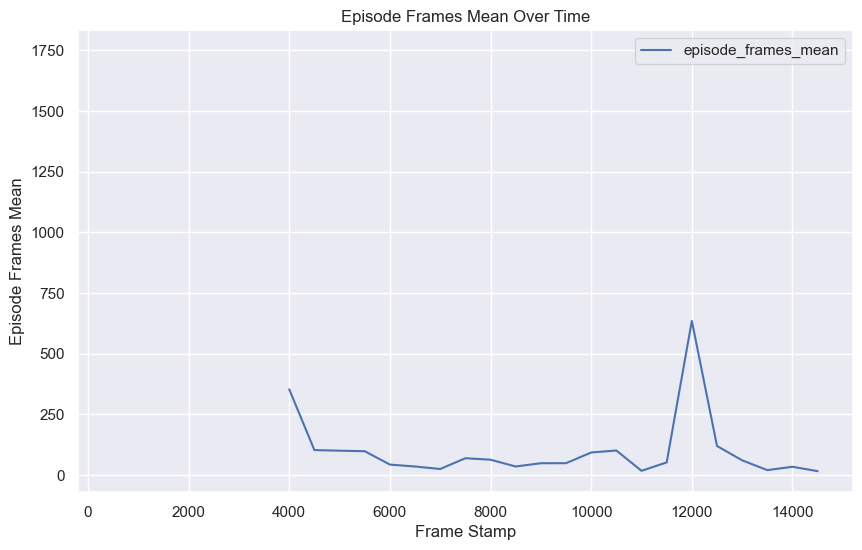

In [268]:
metric = "episode_frames_mean"
plt.figure(figsize=(10, 6))
plt.plot(df['frame_stamp'], df[metric], label=metric)
plt.xlabel('Frame Stamp')
plt.ylabel(metric.replace('_', ' ').title())
plt.title(f'{metric.replace("_", " ").title()} Over Time')
plt.legend()
plt.grid(True)
plt.show()

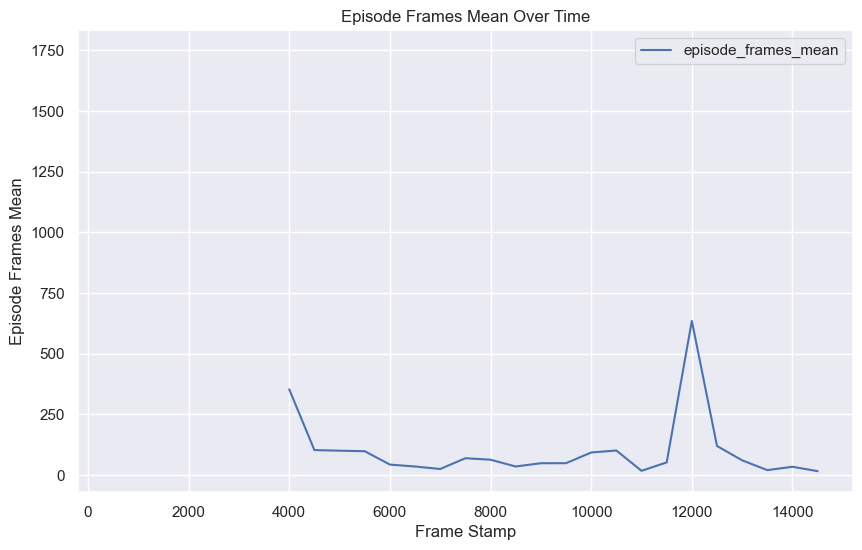

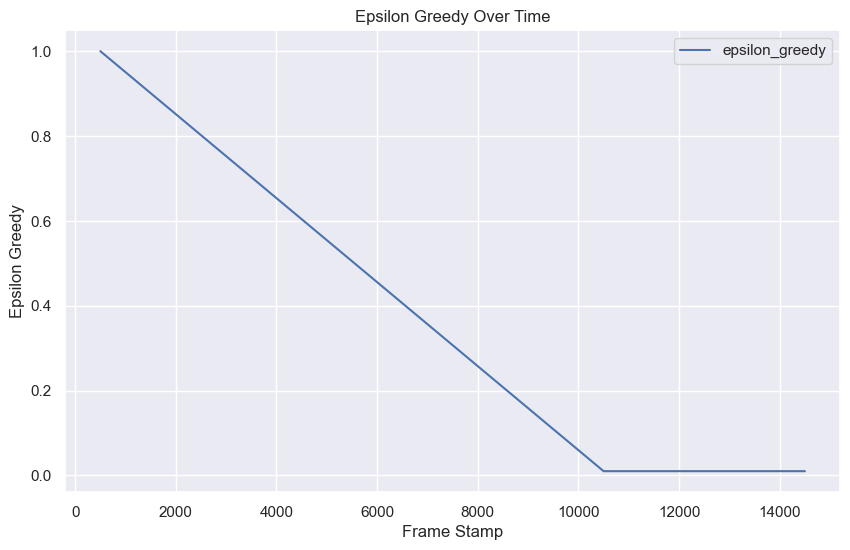

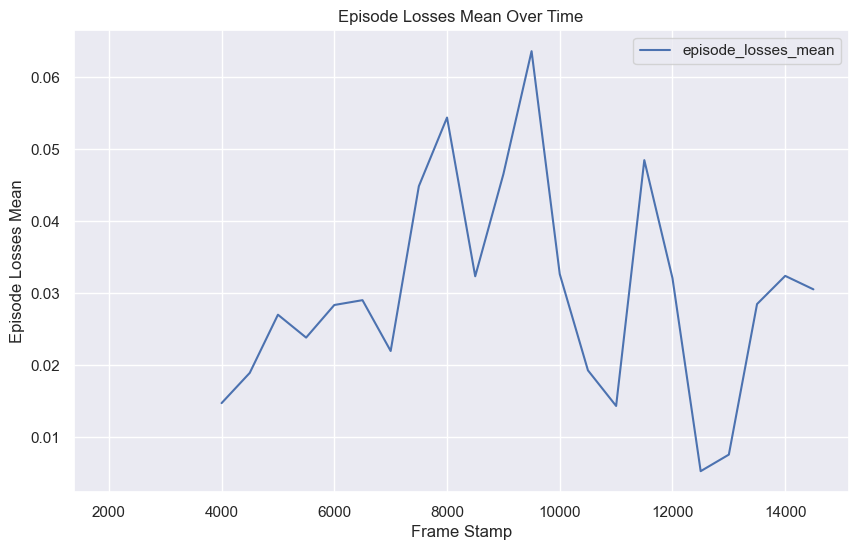

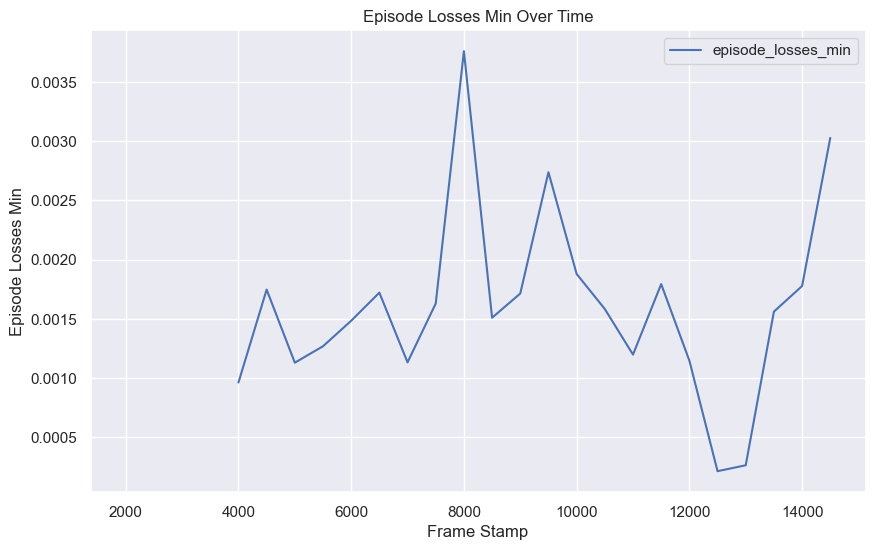

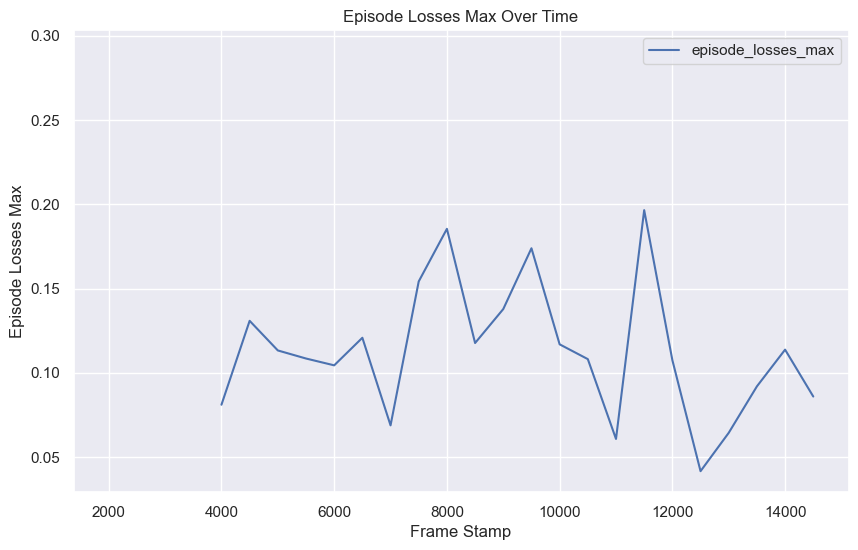

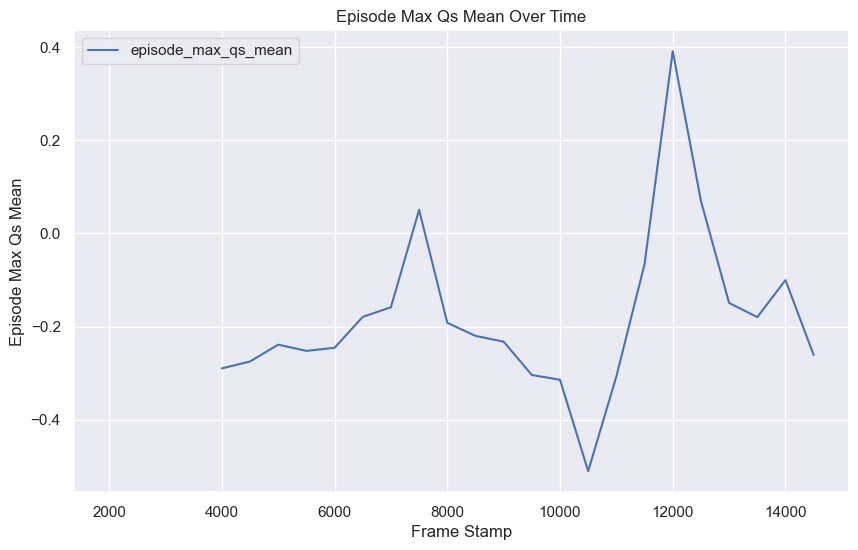

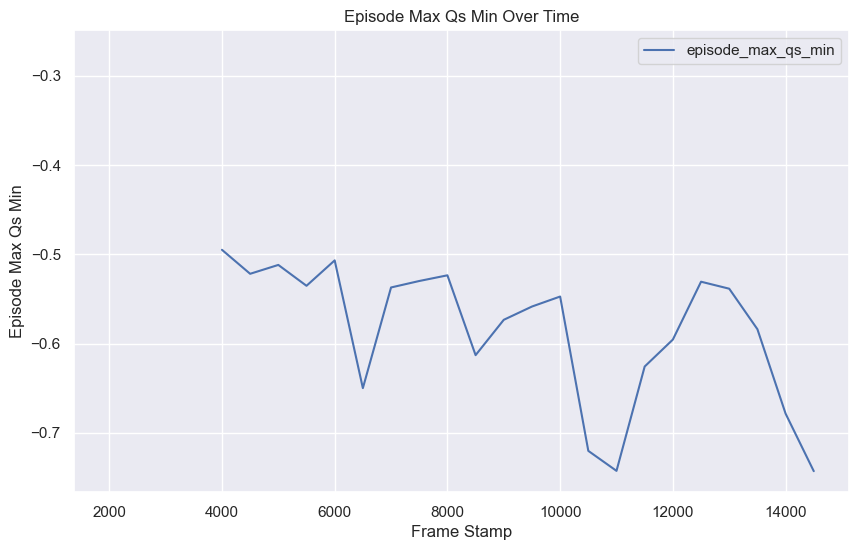

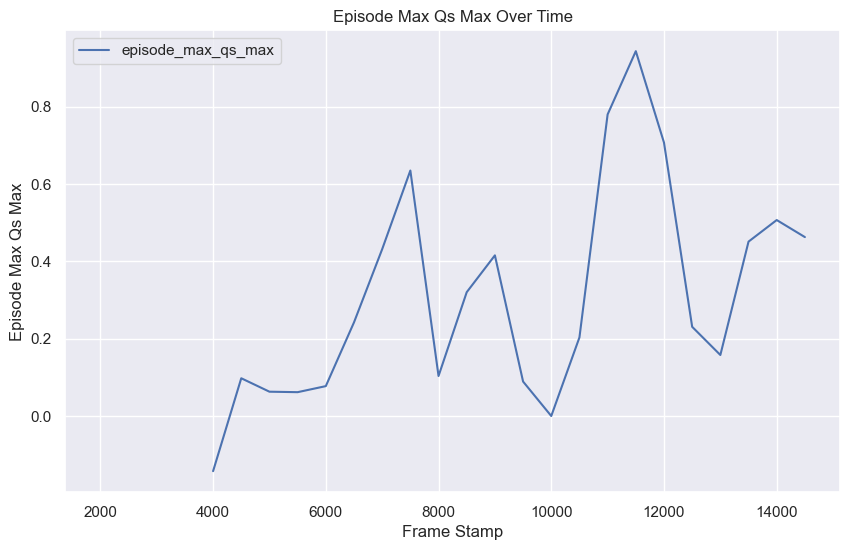

In [254]:
def plot_metrics(df):
    metrics_to_plot = [
        'episode_frames_mean', 'epsilon_greedy',
        'episode_losses_mean', 'episode_losses_min', 'episode_losses_max',
        'episode_max_qs_mean', 'episode_max_qs_min', 'episode_max_qs_max',
        
    ]

    for metric in metrics_to_plot:
        if metric in df.columns:
            plt.figure(figsize=(10, 6))
            plt.plot(df['frame_stamp'], df[metric], label=metric)
            plt.xlabel('Frame Stamp')
            plt.ylabel(metric.replace('_', ' ').title())
            plt.title(f'{metric.replace("_", " ").title()} Over Time')
            plt.legend()
            plt.grid(True)
            plt.show()

# Example usage
plot_metrics(df)

In [255]:
# rb_buffer = agent.replay_buffer
# buffer = rb_buffer.buffer

# examples = [(transition[0], transition[1]) for transition in buffer]
# example_strings = [f"{state}_{action}" for state, action in examples]
# unique_examples, counts = np.unique(example_strings, return_counts=True)
# example_entropy = entropy(counts, base=2)

In [256]:
# len(unique_examples)

In [257]:
# counts.sort()
# counts

In [258]:
# example_entropy

In [259]:

# normalized_rb = rb_buffer.normalize_replay_buffer()
# normalized_rb_entropy = normalized_rb.calculate_buffer_entropy()
# buffer_normed = normalized_rb.buffer


# examples_normalized = [(transition[0], transition[1]) for transition in buffer_normed]
# example_strings_normalized = [f"{state}_{action}" for state, action in examples_normalized]
# len(example_strings_normalized)


In [260]:
# unique_examples, counts = np.unique(example_strings_normalized, return_counts=True)
# len(unique_examples)

In [261]:
# counts

In [262]:
# example_entropy_normed = entropy(counts, base=2)
# example_entropy_normed

In [263]:
# normalized_rb_entropy

In [264]:
# def randomly_step_through_env(env):
#     is_terminated = False
#     truncated = False
#     visited_states = set()
#     recorded_states = []

#     while not is_terminated and not truncated:
#         # Sample a random action from the action space
#         action = env.action_space.sample()

#         # Take a step in the environment
#         s_prime, reward, is_terminated, truncated, info = env.step(action)

#         # Convert state to a hashable type (e.g., tuple) if it's not already
#         s_prime_hashable = (
#             tuple(s_prime) if isinstance(s_prime, (list, np.ndarray)) else s_prime
#         )

#         # Check if the state is new
#         if s_prime_hashable not in visited_states:
#             visited_states.add(s_prime_hashable)
#             recorded_states.append(s_prime)
#             print(
#                 f"New State: {s_prime}, Action: {action}, Reward: {reward}, Terminated: {is_terminated}, Truncated: {truncated}, Info: {info}"
#             )

#     print("Reached terminal state or truncated.")
#     return recorded_states


# # Example usage:
# # Assuming `train_env` is your environment instance
# randomly_step_through_env(train_env)

In [265]:
# loss_records, bm_error = run_distribution_correction_experiment(
#         tau=opts.tau,
#         seed=opts.seed,
#         run_id=opts.run_id,
#         rows=opts.rows,
#         cols=opts.cols,
#         start_state=opts.start_state,
#         p_success=opts.p_success,
#         terminal_states=opts.terminal_states,
#         num_steps=opts.num_steps,
#         gamma=opts.gamma,
#         min_samples=opts.min_samples,
#         batch_size=opts.batch_size,
#         train_max_iterations=opts.train_max_iterations,
#         neural_fit_mode=opts.neural_fit_mode,
#         algorithm=opts.algorithm,
#         logger=logger,
#     )

In [266]:
# loss_records